In [1]:
%pylab inline --no-import-all
import cv2
import os

Populating the interactive namespace from numpy and matplotlib


In [654]:
def to_degrees(angle):
    return int(angle * 180 / np.pi)

def to_radians(angle):
    return angle / 180 * np.pi

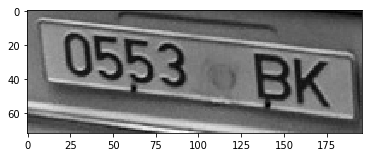

In [696]:
plates_dir = "data/borders/"
plate_file = os.path.join(plates_dir, os.listdir(plates_dir)[1])
img = cv2.imread(plate_file, cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

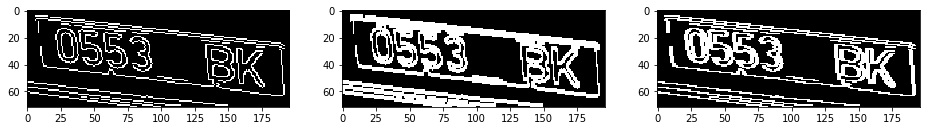

In [697]:
edges = cv2.Canny(img, 150, 220)
edgesHor = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3)))
edgesVer = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1)))

fig, ax =plt.subplots(1, 3, figsize=(16, 8)) 

ax[0].imshow(edges, cmap='gray')
ax[1].imshow(edgesHor, cmap='gray')
ax[2].imshow(edgesVer, cmap='gray')

In [754]:
def get_lines(img, percentage, threshold, min_angle=0.00001, max_angle=np.pi,
              dilation_kernel=(1, 1), max_angle_diff=2*np.pi, max_len_diff=1000,
              show=False, plot_line_size=2, plot_bad_lines=False):
        

    edges = cv2.Canny(img, 150, 220)
    edges = edgesHor = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, dilation_kernel))
    height, width = img.shape

    hough_lines = cv2.HoughLines(edges, 1, np.pi/90, threshold, min_theta=min_angle, max_theta=max_angle)
    if hough_lines is None:
        return 0, []
    lines_count = int(np.ceil(percentage * len(hough_lines)))
    hough_lines = hough_lines[:lines_count]
    
    if show:
        img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        edges_copy = cv2.cvtColor(edgesHor, cv2.COLOR_GRAY2RGB)

    def bounded(val, low, high):
        if val < low:
            return low
        elif val > high:
            return high
        else:
            return val

    h = height - 1
    w = width - 1
    lines = []
    angles = []

    for i, (rho, theta) in enumerate(hough_lines[:, 0]):            
        sin = np.sin(theta)
        cos = np.cos(theta)
        tan = np.tan(theta)
        y0 = rho * sin
        x0 = rho * cos
        skew = x0*y0 > 0

        x1 = bounded(rho/cos, 0, w)
        y1 = bounded(rho/sin, 0, h)

        x2 = bounded(x0 + (y0-h)*tan, 0, w)
        y2 = bounded(y0 + (x0-w)/tan, 0, h)
        if skew and y2 < y1:
            x1, x2 = x2, x1
        if not skew and y2 > y2:
            x1, x2 = x2, x1

        length = np.sqrt((y1-y2)**2 + (x1-x2)**2)
        line = [(int(x1), int(y1)), (int(x2), int(y2))], (rho, theta)

        if i == 0:
            etalon_len = length
            etalon_angle = theta

        if np.abs(etalon_angle - theta) > max_angle_diff:
            color = (0, 0, 100)
            good = False
        elif np.abs(length - etalon_len) > max_len_diff:
            color = (100, 0, 0)
            good = False
        else:
            color = (0, 100, 0)
            good = True
            lines.append(line)
        angles.append(theta)
        
        if show and (plot_bad_lines or good):
            linesize = plot_line_size if good else 1
            cv2.line(img_copy, *line[0], color, linesize)
            cv2.line(edges_copy, *line[0], color, linesize)

    
    if show:
        Fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.imshow(img_copy)
        ax2.imshow(edges_copy)
    
    return lines

In [755]:
width, height = img.shape

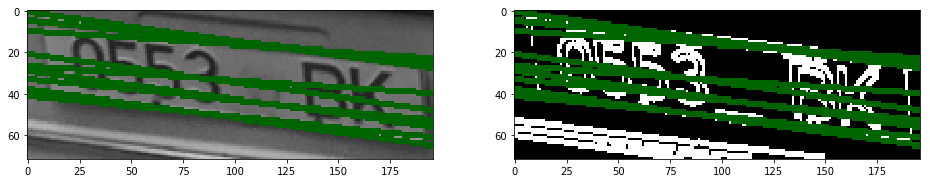

In [756]:
hor_lines = get_lines(img, 1, width//2, dilation_kernel=(1, 3), max_angle_diff=to_radians(3), max_len_diff=width//8, show=True, plot_line_size=2, plot_bad_lines=False)

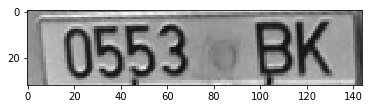

In [757]:
topline, topline_parametric = min(hor_lines, key=lambda l: l[0][0][1] + l[0][1][1])
bottomline, bottomline_parametric = max(hor_lines, key=lambda l: l[0][0][1] + l[0][1][1])

rect_from = np.array([
    topline[0], topline[1], bottomline[1], bottomline[0]
], dtype=np.float32)
rect_to = np.array([
    [0, 0], [144, 0], [144, 32], [0, 32]
], dtype=np.float32)

transform = cv2.getPerspectiveTransform(rect_from, rect_to)

croppedHor = cv2.warpPerspective(img, transform, (144, 32))
plt.imshow(croppedHor, cmap='gray')

In [758]:
angle = np.mean((topline_parametric[1], bottomline_parametric[1]))
normal_angle = angle - np.pi/2

#height, width = croppedHor.shape

-0.122163065935 0.139636321864 0.401435709663


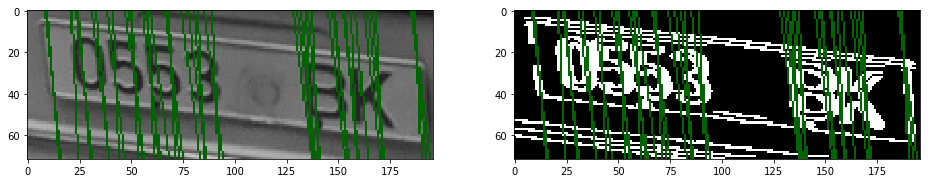

In [759]:
min_angle = normal_angle - np.pi/12
max_angle = normal_angle + np.pi/12
print(min_angle, normal_angle, max_angle)
ver_lines = get_lines(img, 1, int(0.1*height),
                                 min_angle=min_angle, max_angle=max_angle,
                                 max_angle_diff=to_radians(5),
                                 dilation_kernel=(4, 1),
                                 show=True, plot_line_size=1)
#ver_lines

[(8, 0), (16, 71)] [(185, 0), (194, 71)]


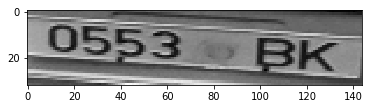

In [760]:
leftline, leftline_parametric = min(ver_lines, key=lambda l: l[0][0][0] + l[0][1][0])
rightline, rightline_parametric = max(ver_lines, key=lambda l: l[0][0][0] + l[0][1][0])


sortkey = lambda l: l[1] # sort by Y axis
leftline = sorted(leftline, key=sortkey)
rightline = sorted(rightline, key=sortkey)
    
print(leftline, rightline)

rect_from = np.array([
    leftline[0], rightline[0], rightline[1], leftline[1]
], dtype=np.float32)
rect_to = np.array([
    [0, 0], [144, 0], [144, 32], [0, 32]
], dtype=np.float32)

transform = cv2.getPerspectiveTransform(rect_from, rect_to)

croppedHor = cv2.warpPerspective(img, transform, (144, 32))
plt.imshow(croppedHor, cmap='gray')

In [761]:
def intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    cos1 = np.cos(rho1)
    sin1 = np.sin(rho1)
    cos2 = np.cos(rho2)
    sin2 = np.sin(rho2)
    
    d = cos1 * sin2 - cos2 * sin1
    d1 = rho1 * sin2 - rho2 * sin1
    d2 = cos1 * rho2 - cos2 * rho1
    
    x = d1 / d
    y = d2 / d
    return x, y

In [762]:
intersection(topline_parametric, leftline_parametric)

(-8.7405272, 6.8006234)